# DTM  Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Nikhil/computed_Hammer02.csv'}>

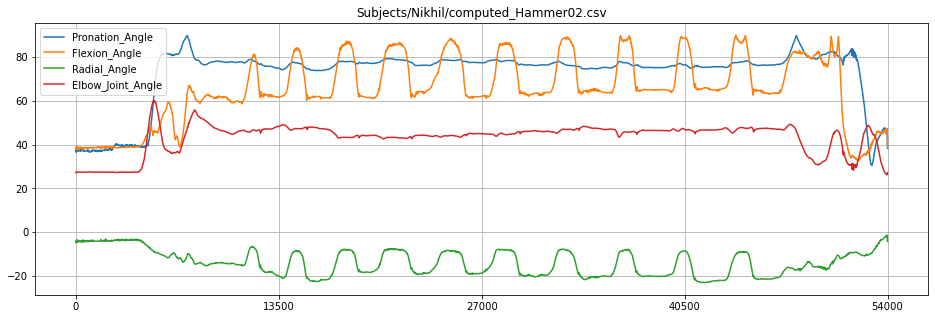

In [2]:
file = 'Subjects/Nikhil/computed_Hammer02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

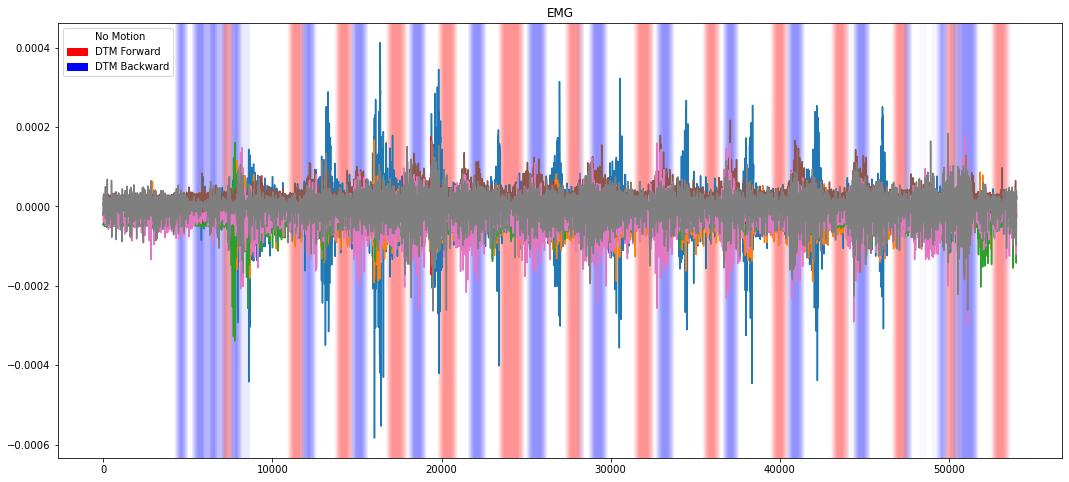

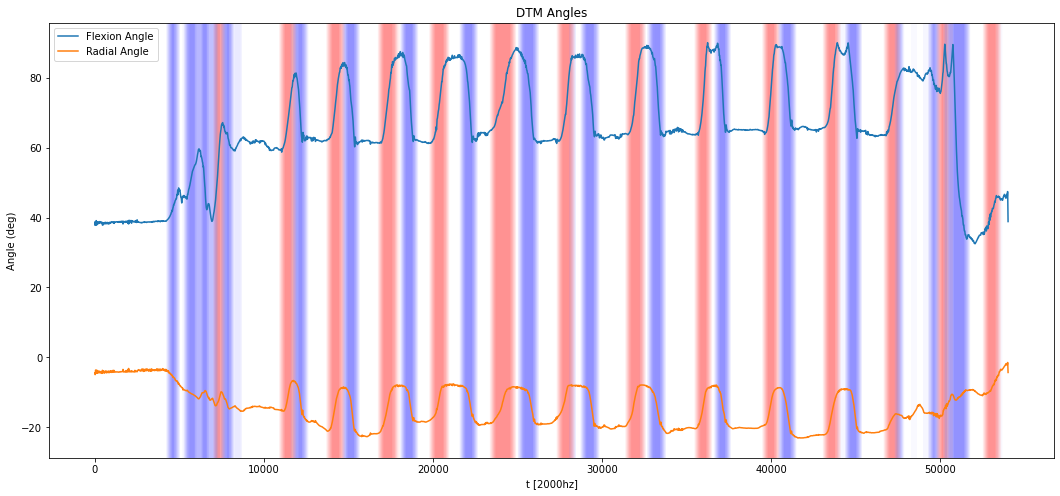

0 -> 59.1044776119403 %
1 -> 19.291044776119403 %
2 -> 21.604477611940297 %


(5360, 400, 8)

In [3]:
X, y = prep_data_DTM(df,400,interval=10,Normalize=False,plot=True,angle_thresh=0.008,rms=False)
X.shape

## File Name Generation

In [22]:
files = []
subjects = ['Fazil','Nikhil','Ingy','Abhishek','Varun','Jai'] #'Fazil/day_04_14_21'

In [23]:
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Bulb.csv',
 'Subjects/Fazil/computed_Bulb01.csv',
 'Subjects/Fazil/computed_Bulb02.csv',
 'Subjects/Fazil/computed_Hammer.csv',
 'Subjects/Fazil/computed_Hammer01.csv',
 'Subjects/Fazil/computed_Hammer02.csv',
 'Subjects/Fazil/computed_Cup.csv',
 'Subjects/Fazil/computed_Cup01.csv',
 'Subjects/Fazil/computed_Cup02.csv',
 'Subjects/Fazil/computed_Screw.csv',
 'Subjects/Fazil/computed_Screw01.csv',
 'Subjects/Fazil/computed_Screw02.csv',
 'Subjects/Nikhil/computed_Bulb.csv',
 'Subjects/Nikhil/computed_Bulb01.csv',
 'Subjects/Nikhil/computed_Bulb02.csv',
 'Subjects/Nikhil/computed_Hammer.csv',
 'Subjects/Nikhil/computed_Hammer01.csv',
 'Subjects/Nikhil/computed_Hammer02.csv',
 'Subjects/Nikhil/computed_Cup.csv',
 'Subjects/Nikhil/computed_Cup01.csv',
 'Subjects/Nikhil/computed_Cup02.csv',
 'Subjects/Nikhil/computed_Screw.csv',
 'Subjects/Nikhil/computed_Screw01.csv',
 'Subjects/Nikhil/computed_Screw02.csv',
 'Subjects/Ingy/computed_Bulb.csv',
 'Subjects/Ingy/comp

In [24]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [25]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    b,a = signal.butter(1, 50,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
    return files_df

In [26]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [27]:
files_df = filter_df(files_df)

## Data Augumentation

### Gausian Noise

In [11]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

44

### Rearrange 

In [15]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [16]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

72

## Data Prep Pipeline

### Parameters

In [28]:
window = 250
interval = 30
Normalize = False
rms = False
angle_thresh_DTM = 0.008

In [29]:
X_dtm, y_dtm = multiple_prep_data_DTM(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)
print(X_dtm.shape,y_dtm.shape)


(151830, 250, 8) (151830, 3)


In [ ]:
np.save('X_test_raw',X_dtm)
np.save('y_test_raw',y_dtm)

## Whole Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [10]:
# X = X_dtm.reshape((X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2]))
# old_range = [X.min(),X.max()]
# new_range = [-1,1]
# scale_param = np.array([old_range,new_range])
# X = map_it(X,old_range,new_range)
# np.save('scale_param',scale_param)
# X = min_max(X)
# X = norm(X)
# X_dtm = X.reshape(X_dtm.shape)

# X = []
# for x in tqdm(X_dtm):
#     X.append(map_it(x,
#                     (x.min(),x.max()),
#                     (-1,1)))
# X_dtm = np.array(X)

In [15]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [16]:
X_mean = np.zeros(X_dtm[0].shape)
for x in X_dtm:
    X_mean = X_mean + x
X_mean = X_mean/X_dtm.shape[0]
X_std = np.sqrt(variance(X_dtm))
np.save('mean_std',np.array([X_mean,X_std]))

In [17]:
X = []
for x in tqdm(X_dtm):
    X.append((x-X_mean)/X_std)
X_dtm = np.array(X)

In [38]:
np.save('prepared_data/X_dtm_rearr_tw',X_dtm)
np.save('prepared_data/y_dtm_rearr_tw',y_dtm)

In [2]:
X_dtm = np.load('prepared_data/X_dtm_rearr_tw.npy')
y_dtm = np.load('prepared_data/y_dtm_rearr_tw.npy')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_dtm, y_dtm,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(121464, 250, 8)
(30366, 250, 8)
(121464, 3)
(30366, 3)


In [31]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [32]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [33]:
print(count(y_train))
print(count(y_test))

0 - 68645 [ 56.51468747941777 %]
1 - 14529 [ 11.961568859909109 %]
2 - 38290 [ 31.523743660673123 %]
None
0 - 17228 [ 56.734505697161296 %]
1 - 3544 [ 11.670947770532832 %]
2 - 9594 [ 31.59454653230587 %]
None


# InceptionTime Trainer

In [34]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [51]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=64,nb_epochs=10,nb_filters=64,
                            depth=20, kernel_size=41)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_827 (Conv1D)             (None, 250, 32)      256         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_156 (MaxPooling1D (None, 250, 8)       0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_828 (Conv1D)             (None, 250, 64)      81920       conv1d_827[0][0]                 
___________________________________________________________________________________________

In [ ]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/10
1898/1898 [==============================] - 617s 318ms/step - loss: 0.9366 - accuracy: 0.5628 - val_loss: 0.9770 - val_accuracy: 0.5676
Epoch 2/10
1898/1898 [==============================] - 642s 338ms/step - loss: 0.9249 - accuracy: 0.5640 - val_loss: 1.2259 - val_accuracy: 0.2398
Epoch 3/10
1898/1898 [==============================] - 643s 339ms/step - loss: 0.9191 - accuracy: 0.5647 - val_loss: 0.9450 - val_accuracy: 0.5470
Epoch 4/10
1898/1898 [==============================] - 643s 339ms/step - loss: 0.9087 - accuracy: 0.5677 - val_loss: 1.0854 - val_accuracy: 0.3432
Epoch 5/10
1898/1898 [==============================] - 643s 339ms/step - loss: 0.8981 - accuracy: 0.5748 - val_loss: 0.9995 - val_accuracy: 0.5387
Epoch 6/10
 550/1898 [=======>......................] - ETA: 7:11 - loss: 0.8883 - accuracy: 0.5775

In [ ]:
clf.model = load_model('models/DTM_250_tw_rearr.hdf5')

In [12]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}_tw_rearr.hdf5'.format(window))

C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}_raw.hdf5'.format(window))

In [ ]:
best_model = load_model('best_model.hdf5')
best_model.save('models/DTM_{}_aug_tw.hdf5'.format(window))

In [22]:
system_sleep()

## Testing

In [25]:
model = load_model('best_model.hdf5')

In [33]:
# mx_scaler = load(open('min_max.pkl', 'rb'))
# std_scaler = load(open('standard_scaler.pkl', 'rb'))

# X = mx_scaler.transform(X)
# X = std_scaler.transform(X)
X = X_dtm.reshape(X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2])
scale_param = np.load('scale_param.npy')
print(scale_param)
X = map_it(X,scale_param[0],scale_param[1])
X_dtm = X.reshape(X_dtm.shape)

[[-2.50412559  1.50388032]
 [-1.          1.        ]]


In [34]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]

In [35]:
X = []
for x in tqdm(X_dtm):
    X.append((x-X_mean)/X_std)
X_dtm = np.array(X)

In [36]:
model.evaluate(X_dtm,y_dtm)

4745/4745 [==============================] - 51s 11ms/step - loss: 35298.5703 - accuracy: 0.3006


[35298.5703125, 0.3005908131599426]

## Plot Results

In [13]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [14]:
metrics_df

,precision,accuracy,recall,duration
0,0.973968,0.967858,0.954954,4358.470889


<AxesSubplot:title={'center':'Loss'}>

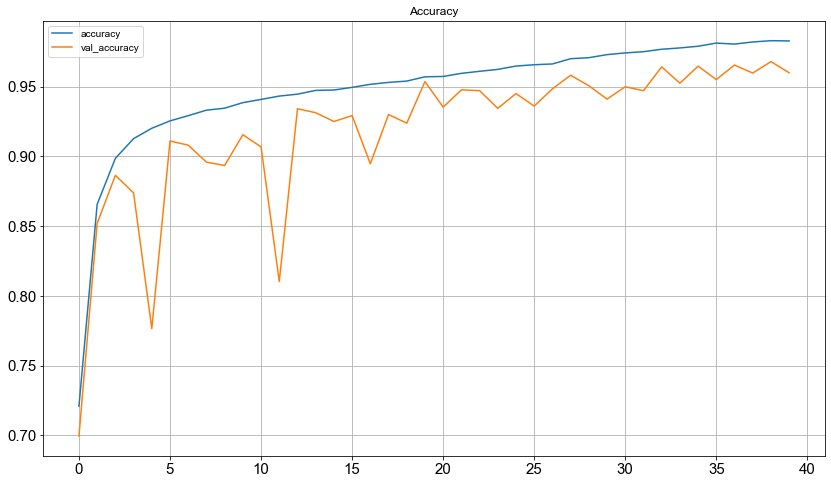

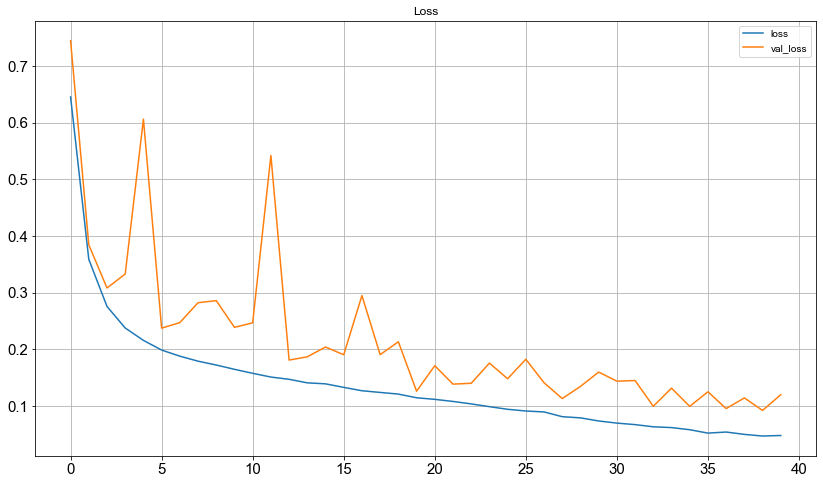

In [15]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
system_sleep()